In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.04114848, -0.02758827, -0.00500454, -0.02935486], dtype=float32)

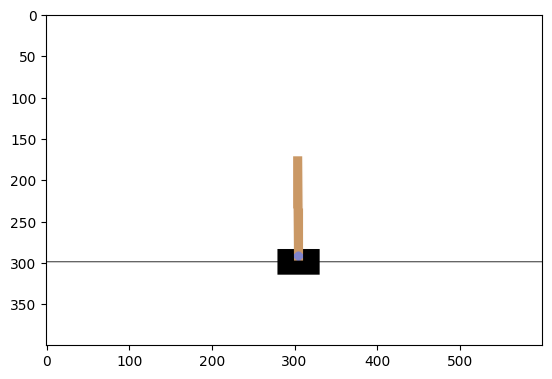

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

改2：离散熵用求和
代码位置：ModelAction 类中，计算动作熵的方式从单一动作的负对数概率改为基于整个动作分布的熵求和。
修改意义：

背景：SAC算法的核心是最大化策略的熵，以鼓励探索。熵的计算需要考虑整个动作分布的概率，而不仅仅是采样动作的概率。离散动作空间的熵公式为：$ H(\pi) = -\sum_a \pi(a|s) \log \pi(a|s) $。
作用：

原代码仅计算采样动作的熵（entropy = -log_prob），忽略了动作分布的整体特性，可能导致熵估计偏低，探索不足。
修改后使用整个动作分布的熵公式（entropy = -prob * torch.log(prob + 1e-8).sum(dim=1)），更准确地反映了策略的随机性，符合SAC算法的熵正则化目标。


效果：更准确的熵计算增强了探索能力，使策略更倾向于尝试不同动作，从而避免过早收敛到次优解。

In [3]:
import torch
import random


class ModelAction(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
                    torch.nn.Linear(4, 128),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, 2),
                    torch.nn.Softmax(dim=1),
                )

    def forward(self, state):
        prob = self.model(state)  

        # 采样动作
        action = [random.choices(range(2), weights=p.tolist(), k=1)[0] for p in prob]  # 采样一个动作

        # 计算熵
        # prob[0, action] 是采样动作 action 的概率
        #log_prob = torch.log(prob + 1e-7)  # 避免 log(0) 加小 epsilon
        #entropy = -log_prob  # 单个动作的熵贡献，-log π(a|s)

        # 改2：离散熵用求和
        #[b, 2]
        entropy = prob * torch.log(prob + 1e-8)

        #所有动作的熵求和
        #[b, 2] -> [b, 1]
        entropy = -entropy.sum(dim=1, keepdim=True)
        # 或者更准确的熵估计（基于整个分布）
        # 熵 = -∑ π(a|s) log π(a|s)，可以使用 prob 直接计算期望
        #entropy = -torch.sum(prob * torch.log(prob + 1e-7))  # 整个分布的熵

        return action, entropy.reshape(-1,1), prob


model_action = ModelAction()

model_action(torch.randn(2,4))

([1, 1],
 tensor([[0.6677],
         [0.6200]], grad_fn=<ViewBackward0>),
 tensor([[0.3878, 0.6122],
         [0.3111, 0.6889]], grad_fn=<SoftmaxBackward0>))

改4：输出是二维以匹配后面的与prob相乘
代码位置：ModelValue 类中，价值网络输出从1维改为2维。
修改意义：
背景：在离散动作空间的SAC中，价值网络需要为每个动作输出一个Q值（对应于动作空间的维度）。CartPole-v1的动作空间是离散的（**2个动作：左或右**），因此价值网络的输出需要是2维，以匹配动作概率的维度。
作用：
原代码中价值网络输出可能是1维，无法与动作概率（2维）进行点乘或加权操作。
修改后，价值网络输出2维Q值（对应两个动作），可以与动作概率分布（prob）逐元素相乘，计算期望价值。
效果：这一修改使价值网络的输出与动作概率分布兼容，保证了策略损失和价值损失的计算正确性。


改9：删去一层
代码位置：ModelValue 类中，删去价值网络中的一层隐藏层。
修改意义：
背景：神经网络的深度和复杂度需要与任务的复杂性匹配。CartPole-v1是一个相对简单的环境，过深的网络可能导致过拟合或训练困难。
作用：
删除一层隐藏层（从多层简化为两层：Linear(4, 128) -> ReLU -> Linear(128, 2)），降低了价值网络的复杂度，减少了过拟合风险。
简化网络结构可能使梯度传播更稳定，适合CartPole-v1的简单状态空间（4维）。
效果：减少网络复杂性提高了训练效率和稳定性，适合任务需求。
**实际运行时，多加的这一层反而导致训练效果变差**

改10：去掉动作输入
代码位置：ModelValue 类中，去掉动作输入，使价值网络仅接受状态输入。
修改意义：
背景：SAC算法中，价值网络（Q网络）通常为每个动作输出一个Q值（即$ Q(s,a) $），但在离散动作空间中，Q网络可以设计为仅接受状态输入，输出所有动作的Q值向量。这种设计在CartPole-v1（动作空间为2）中是可行的。
作用：
原代码中，价值网络将状态和动作拼接作为输入（例如输入维度为5，可能包含4维状态+1维动作）。这要求网络为每个状态-动作对单独预测Q值，增加了模型复杂度，且可能引入不必要的噪声，因为动作信息可以通过输出维度隐式建模。
修改后，价值网络仅接受4维状态输入，输出2维Q值（对应两个动作），简化了网络结构，直接预测所有动作的Q值。
效果：这一修改降低了模型的输入复杂性，使价值网络更专注于学习状态到Q值的映射，减少了过拟合风险，提高了训练稳定性。
**加上动作输入后，训练效果其差**

In [6]:
class ModelValue(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(4, 128),#改10：去掉动作输入
            torch.nn.ReLU(),
            #torch.nn.Linear(128, 128),
            #torch.nn.ReLU(),#改9：删去一层
            # 改4：输出是二维以匹配后面的与prob相乘
            torch.nn.Linear(128, 2),
        )

    def forward(self, state):
        #[b, 5] -> [b, 1]
        return self.sequential(state)


model_value1 = ModelValue()
model_value2 = ModelValue()

model_value_next1 = ModelValue()
model_value_next2 = ModelValue()

model_value_next1.load_state_dict(model_value1.state_dict())
model_value_next2.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4))

tensor([[-0.0095, -0.0516],
        [ 0.0274, -0.1135]], grad_fn=<AddmmBackward0>)

In [7]:
import numpy as np


def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)
    #[1, 4] -> [1, 2]
    action, _, __ = model_action(state)

    return action


get_action([1, 2, 3, 4])

[1]

改1：要收集足够多的数据
代码位置：update_data 函数中，循环收集至少200条数据，并限制样本池大小为10000。

修改意义：

背景：SAC是一种基于经验回放（Replay Buffer）的强化学习算法，需要从环境中收集足够多的数据样本以保证策略和价值函数的训练稳定性。样本池过小会导致模型学习到的策略缺乏多样性，容易陷入局部最优。
作用：
通过确保每次更新至少收集200条新数据，增加了数据的多样性，有助于模型探索不同的状态-动作对，改善策略的泛化能力。
限制样本池最大为10000条，避免内存占用过大，同时通过删除最旧的数据保持样本的新鲜度，适应环境动态变化。
效果：这一修改保证了训练过程中有足够的数据支持，减少了过拟合的风险，提升了模型的稳定性。

In [8]:
#样本池
datas = []


### 改1：要收集足够多的数据
#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step(action[0])

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 10000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 10000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

/home/yuchen/Fdisk/miniconda3/envs/RL-py39/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


((201, 0), 201)

改8： 返回数据类型 action F->L reward:L->F
类型没改好，动作只有0,1所以是Long整形，reward是奖励用浮点数

In [9]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    # 改8： 返回数据类型 action F->L reward:L->F
    #[b, 4]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 4]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 4)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

/tmp/ipykernel_461985/3749404182.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)


(tensor([[-0.1215, -0.4311,  0.0837,  0.6112],
         [ 0.0460, -0.0319, -0.0398,  0.0421],
         [ 0.0215,  0.7482, -0.0409, -1.1462],
         [-0.0079,  1.1196,  0.0598, -1.1602],
         [ 0.0582,  0.3375,  0.0038,  0.0488]]),
 tensor([[1],
         [1],
         [1],
         [0],
         [1]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[-0.1301, -0.2373,  0.0959,  0.3461],
         [ 0.0454,  0.1638, -0.0390, -0.2629],
         [ 0.0364,  0.9438, -0.0638, -1.4514],
         [ 0.0145,  0.9238,  0.0366, -0.8494],
         [ 0.0649,  0.5326,  0.0047, -0.2427]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [10]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action[0])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

30.0

In [11]:
def soft_update(model, model_next):
    for param, param_next in zip(model.parameters(), model_next.parameters()):
        #以一个小的比例更新
        value = param_next.data * 0.995 + param.data * 0.005
        param_next.data.copy_(value)


soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [12]:
import math

#这也是一个可学习的参数
alpha = torch.tensor(math.log(0.01))
alpha.requires_grad = True

alpha

tensor(-4.6052, requires_grad=True)

改5：二维的value和prob结合求其期望
代码位置：get_target 函数中，target价值按动作概率加权求和。
修改意义：

背景：SAC算法的目标价值（target）需要考虑下一状态的动作分布，计算期望Q值并加上熵正则化项。公式为：$ \mathbb{E}_{\pi(a'|s')}[Q(s',a') - \alpha \log \pi(a'|s')] $。
作用：

原代码直接使用单一动作的Q值，忽略了动作分布的期望。
修改后，通过将价值（target）与动作概率（prob）相乘并求和，计算下一状态的期望Q值，并加上熵项（target += alpha.exp() * entropy）。


效果：这一修改确保了目标价值的计算符合SAC算法的理论框架，增强了训练的稳定性。

In [13]:
def get_target(reward, next_state, over):
    #首先使用model_action计算动作和动作的熵
    #[b, 4] -> [b, 1],[b, 1]
    action, entropy, prob= model_action(next_state)

    #评估next_state的价值
    #[b, 4],[b, 1] -> [b, 1]
    target1 = model_value_next1(next_state)
    target2 = model_value_next2(next_state)

    #取价值小的,这是出于稳定性考虑
    #[b, 1]
    target = torch.min(target1, target2)

    # 改5：二维的value和prob结合求其期望
    target = (prob * target)
    target = target.sum(dim=1, keepdim=True)

    #exp和log互为反操作,这里是把alpha还原了
    #这里的操作是在target上加上了动作的熵,alpha作为权重系数
    #[b, 1] - [b, 1] -> [b, 1]
    target += alpha.exp() * entropy

    #[b, 1]
    target *= 0.99
    target *= (1 - over)
    target += reward

    return target


get_target(reward, next_state, over).shape

torch.Size([64, 1])

改3：熵求和后变为1x1的了，value也要加权求和
代码位置：get_loss_action 函数中，value按动作概率加权求和。
修改意义：

背景：SAC算法中，动作策略的损失函数需要考虑状态-动作对的价值，而价值函数的输出需要与动作概率结合，计算期望价值。
作用：

原代码可能未正确对value进行加权，导致动作策略的损失函数无法准确反映动作分布的期望价值。
修改后，value按动作概率加权（value *= prob; value = value.sum(dim=1)），计算的是动作策略的期望价值，这与SAC算法中策略优化的目标一致，即优化 $ \mathbb{E}_{\pi(a|s)}[Q(s,a) - \alpha \log \pi(a|s)] $。


效果：加权求和使动作策略的损失更贴近理论目标，提升了策略优化的准确性，促进了收敛。

In [14]:
def get_loss_action(state):
    #计算action和熵
    #[b, 4] -> [b, 1],[b, 1]
    action, entropy, prob = model_action(state)

    #使用两个value网络评估action的价值
    #[b, 4],[b, 1] -> [b, 1]
    value1 = model_value1(state)
    value2 = model_value2(state)

    #取价值小的,出于稳定性考虑
    #[b, 1]
    value = torch.min(value1, value2)

    #alpha还原后乘以熵,这个值期望的是越大越好,但是这里是计算loss,所以符号取反
    #[1] - [b, 1] -> [b, 1]
    loss_action = -alpha.exp() * entropy

    # 改3：熵求和后变为1x1的了，value也要加权求和
    #按概率对value进行加权
    value *= prob
    value = value.sum(dim=1, keepdim=True)
    #减去value,所以value越大越好,这样loss就会越小
    loss_action -= value #图片公式里用了V，这里没用到

    return loss_action.mean(), entropy


get_loss_action(state)

(tensor(0.0309, grad_fn=<MeanBackward0>),
 tensor([[0.6903],
         [0.6882],
         [0.6330],
         [0.6345],
         [0.6858],
         [0.6683],
         [0.6068],
         [0.6033],
         [0.6917],
         [0.6783],
         [0.6314],
         [0.6772],
         [0.6876],
         [0.6669],
         [0.6926],
         [0.6848],
         [0.6860],
         [0.6385],
         [0.6508],
         [0.6520],
         [0.6921],
         [0.6507],
         [0.6920],
         [0.5766],
         [0.6880],
         [0.6924],
         [0.6198],
         [0.5522],
         [0.6852],
         [0.6649],
         [0.6804],
         [0.6740],
         [0.6761],
         [0.6493],
         [0.6751],
         [0.6756],
         [0.6658],
         [0.6787],
         [0.6769],
         [0.6892],
         [0.6098],
         [0.6632],
         [0.6858],
         [0.6761],
         [0.6895],
         [0.6772],
         [0.6619],
         [0.6907],
         [0.6874],
         [0.6920],
        

改6：取对应动作的value值 [b,2]->[b,1]
代码位置：train 函数中，价值损失计算时使用gather提取对应动作的Q值。

修改意义：

背景：价值网络的损失函数需要比较预测的Q值与目标Q值，而预测的Q值需要对应实际采取的动作。
作用：
原代码未能正确匹配实际动作。
修改后，使用gather函数根据实际动作索引（action）提取对应的Q值，确保价值损失计算的是实际执行动作的Q值与目标的差异。
效果：这一修改提高了价值网络的训练精度，使其更准确地逼近真实Q值。

改7：学习率大小
代码位置：train 函数中，调整优化器的学习率。

修改意义：

背景：学习率是优化器的重要超参数，过高可能导致训练不稳定，过低可能导致收敛过慢。SAC算法通常需要为动作网络和价值网络设置不同的学习率。
作用：
动作网络的学习率设为1e-3，价值网络为1e-2，alpha为1e-2，这些值是直接复制参考代码的值。
合理的学习率平衡了动作策略和价值函数的更新速度，避免某一部分更新过快导致训练失衡。
效果：优化学习率提高了训练的稳定性，加速了收敛。

In [15]:
def train():
    #改7： 学习率大小
    optimizer_action = torch.optim.Adam(model_action.parameters(), lr=1e-3)
    optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=1e-2)
    optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=1e-2)

    #alpha也是要更新的参数,所以这里要定义优化器
    optimizer_alpha = torch.optim.Adam([alpha], lr=1e-2)

    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(100):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #对reward偏移,为了便于训练
            reward = (reward + 8) / 8

            #计算target,这个target里已经考虑了动作的熵
            #[b, 1]
            target = get_target(reward, next_state, over)
            target = target.detach()

            # 改6：取对应动作的value值 [b,2]->[b,1]
            #计算两个value
            value1 = model_value1(state).gather(dim=1, index=action.to(torch.int64))
            value2 = model_value2(state).gather(dim=1, index=action.to(torch.int64))

            #计算两个loss,两个value的目标都是要贴近target
            loss_value1 = loss_fn(value1, target)
            loss_value2 = loss_fn(value2, target)

            #更新参数
            optimizer_value1.zero_grad()
            loss_value1.backward()
            optimizer_value1.step()

            optimizer_value2.zero_grad()
            loss_value2.backward()
            optimizer_value2.step()

            #使用model_value计算model_action的loss
            loss_action, entropy = get_loss_action(state)
            optimizer_action.zero_grad()
            loss_action.backward()
            optimizer_action.step()

            #熵乘以alpha就是alpha的loss
            #[b, 1] -> [1]
            loss_alpha = (entropy + 1).detach() * alpha.exp()
            loss_alpha = loss_alpha.mean()

            #更新alpha值
            optimizer_alpha.zero_grad()
            loss_alpha.backward()
            optimizer_alpha.step()

            #增量更新next模型
            soft_update(model_value1, model_value_next1)
            soft_update(model_value2, model_value_next2)

        if epoch % 10 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, len(datas), alpha.exp().item(), test_result)


train()

0 412 0.002476826310157776 16.3
10 3143 0.00010455201845616102 180.9
20 5968 2.707117164391093e-05 117.5
30 8470 9.042170859174803e-06 167.9
40 10000 3.2324410312867258e-06 117.2
50 10000 1.187405700875388e-06 134.8
60 10000 4.399724389259063e-07 197.9
70 10000 1.6337584440861974e-07 106.8
80 10000 5.87634403359516e-08 167.2
90 10000 2.1969018604295343e-08 200.0


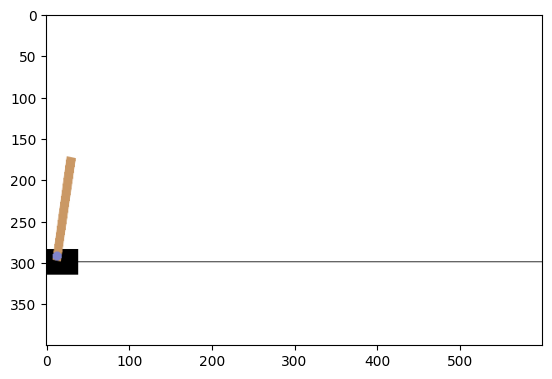

200.0

In [19]:
test(play=True)